In [1]:
import gc
import os
import string

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchinfo import summary

from collections import namedtuple
import PyPDF3

In [2]:
jtplot.style("gruvboxd")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
device

device(type='cuda')

In [5]:
SEED = 42

if device == "cuda":
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

In [6]:
DATA_DIR = os.getcwd().replace('notebooks', 'data')

with open(os.path.join(DATA_DIR, 'anna.txt'), 'r') as file:
    text = file.read()

In [7]:
text[:120]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverything was in confusion i'

In [8]:
unique_chars = list(set(text))

In [9]:
len(unique_chars)

83

In [10]:
unique_chars

['I',
 ')',
 'M',
 'X',
 'V',
 'F',
 'k',
 'z',
 'T',
 'w',
 'N',
 'C',
 'O',
 'i',
 'K',
 '8',
 'r',
 'q',
 'j',
 '`',
 'e',
 '&',
 'b',
 'v',
 'y',
 'x',
 't',
 ' ',
 '0',
 'G',
 'J',
 '"',
 'h',
 'u',
 'B',
 '9',
 'U',
 'P',
 'n',
 ':',
 '$',
 'L',
 '.',
 ',',
 "'",
 '@',
 '%',
 'D',
 'c',
 '?',
 'l',
 'A',
 ';',
 'a',
 '-',
 '_',
 '*',
 'H',
 'E',
 '7',
 'Q',
 '(',
 's',
 'p',
 'Z',
 'W',
 '4',
 '/',
 'o',
 'd',
 '5',
 'Y',
 'g',
 '2',
 'S',
 '\n',
 'R',
 'f',
 '3',
 '!',
 'm',
 '1',
 '6']

In [11]:
chars2int = {char : unique_chars.index(char) for char in unique_chars}
int2char = {v : k for (k, v) in chars2int.items()}

In [12]:
def encode_text(text, unique_chars = None, extend = False):
    result_tuple = namedtuple('results', ['encoded_text', 'unique_char', 'int2char', 'char2int'])
    
    if unique_chars is None:
        unique_chars = list(set(text))
    else:
        if extend:
            unique_chars.extend(list('#[]{}+-*=!'))
        
    char2int = {char : unique_chars.index(char) for char in unique_chars}
    int2char = {v : k for (k, v) in char2int.items()}
    
    encoded_text = np.array(list(map(lambda x: char2int[x], list(text))))
    
    return result_tuple(encoded_text, unique_chars, int2char, char2int)

In [13]:
train_frac = 0.8
text, val_text = text[:int(len(text)*train_frac)], text[int(len(text)*(train_frac)):]

In [14]:
encoded_text, unique_chars, int2char, char2int = encode_text(text, unique_chars)

In [15]:
def one_hot_convert(arr, n_labels):
    nrows = arr.size
    array = np.zeros(shape = [nrows, n_labels])
    array[np.arange(array.shape[0]), arr.flatten()] = 1.
    
    return array

In [16]:
one_hot_convert(np.array([[1, 2, 3, 5]]), 10)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]])

In [17]:
batch_size = 32
seq_length = 16

In [18]:
numel_seq = batch_size * seq_length

In [19]:
numel_seq

512

In [20]:
encoded_text.shape[0]/numel_seq

3101.91015625

In [21]:
def batch_sequence(arr, batch_size, seq_length):
    numel_seq = batch_size * seq_length
    num_batches = arr.size // numel_seq
    
    arr = arr[: num_batches * numel_seq].reshape(batch_size, -1)
    #print(arr.shape)
    
    batched_data = [(arr[:, n : n + seq_length], arr[:, n + 1 : n + 1 + seq_length])
                    for n in range(0, arr.shape[1], seq_length)]
    
    ### Finalize final array size
    batched_data[-1] = (batched_data[-1][0],
                        np.append(batched_data[-1][1], batched_data[0][1][:, 0].reshape(-1, 1), axis = 1))
    
    ###batched_arr = [arr[n : n + numel_seq].reshape(batch_size, seq_length) for n in range(num_batches)]
    return iter(batched_data), num_batches

In [22]:
batch, _ = batch_sequence(encoded_text, 32, 16)

In [23]:
X, y = next(batch)

In [24]:
X

array([[11, 32, 53, 63, 26, 20, 16, 27, 81, 75, 75, 75, 57, 53, 63, 63],
       [20, 27, 32, 53, 69, 27, 77, 68, 16, 72, 68, 26, 26, 20, 38, 27],
       [26, 16, 53, 72, 20, 69, 24, 27, 13, 38, 75, 13, 26, 42, 31, 75],
       [26, 27, 32, 20, 16, 27,  9, 13, 26, 32, 27, 80, 20, 43, 27, 53],
       [20, 13, 16, 27, 32, 68, 62, 26, 75, 62, 80, 13, 50, 20, 69, 27],
       [20, 26, 20, 16, 62, 22, 33, 16, 72, 43, 27, 53, 62, 27, 62, 68],
       [62, 32, 20, 27,  9, 32, 13, 62, 63, 20, 16, 20, 69, 27, 63, 20],
       [77, 16, 68, 80, 27, 32, 20, 16, 27, 26, 68, 38, 20, 27, 26, 32],
       [77, 68, 16, 20, 42, 75, 75, 31, 57, 53, 23, 20, 27, 24, 68, 33],
       [ 9, 53, 62, 27, 48, 68, 80, 63, 50, 20, 26, 20, 50, 24, 27, 53],
       [20, 27, 51, 50, 20, 25, 20, 24, 27, 51, 50, 20, 25, 53, 38, 69],
       [32, 53, 69, 27, 77, 20, 50, 26, 27, 53, 26, 27, 13, 26, 42, 27],
       [63, 27, 26, 32, 20, 27, 50, 53, 62, 26, 27, 50, 13, 38, 20, 43],
       [24, 27,  9, 32, 13, 48, 32, 27, 48, 32, 13,

In [25]:
y

array([[32, 53, 63, 26, 20, 16, 27, 81, 75, 75, 75, 57, 53, 63, 63, 24],
       [27, 32, 53, 69, 27, 77, 68, 16, 72, 68, 26, 26, 20, 38, 27, 26],
       [16, 53, 72, 20, 69, 24, 27, 13, 38, 75, 13, 26, 42, 31, 75, 75],
       [27, 32, 20, 16, 27,  9, 13, 26, 32, 27, 80, 20, 43, 27, 53, 38],
       [13, 16, 27, 32, 68, 62, 26, 75, 62, 80, 13, 50, 20, 69, 27, 53],
       [26, 20, 16, 62, 22, 33, 16, 72, 43, 27, 53, 62, 27, 62, 68, 68],
       [32, 20, 27,  9, 32, 13, 62, 63, 20, 16, 20, 69, 27, 63, 20, 38],
       [16, 68, 80, 27, 32, 20, 16, 27, 26, 68, 38, 20, 27, 26, 32, 53],
       [68, 16, 20, 42, 75, 75, 31, 57, 53, 23, 20, 27, 24, 68, 33, 27],
       [53, 62, 27, 48, 68, 80, 63, 50, 20, 26, 20, 50, 24, 27, 53, 50],
       [27, 51, 50, 20, 25, 20, 24, 27, 51, 50, 20, 25, 53, 38, 69, 16],
       [53, 69, 27, 77, 20, 50, 26, 27, 53, 26, 27, 13, 26, 42, 27, 57],
       [27, 26, 32, 20, 27, 50, 53, 62, 26, 27, 50, 13, 38, 20, 43, 27],
       [27,  9, 32, 13, 48, 32, 27, 48, 32, 13, 50,

In [26]:
def one_hot_encode(arr, n_labels):
    
    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)
    
    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [27]:
len(unique_chars)

83

In [28]:
#X_ = one_hot_convert(X, 90)
X_ = one_hot_encode(X, len(unique_chars))

In [29]:
X.shape

(32, 16)

In [30]:
X_.shape

(32, 16, 83)

\begin{array}{ll} \\
        i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
        f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
        g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
        o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
        c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
        h_t = o_t \odot \tanh(c_t) \\
    \end{array}

In [32]:
def get_text(fpath, start_page = 1):
    with open(fpath, "rb") as f:
        pdf = PyPDF3.PdfFileReader(f)
        text = str()
        for page_num in range(start_page-1, pdf.numPages):
            page = pdf.getPage(page_num)
            text = text + ' ' + page.extractText()
    return text.lower()

In [33]:
len(text)

1588178

In [34]:
len(val_text)

397045

In [35]:
print(val_text[:1000])

at it may be, but still it ought to be treated a little more
respectfully. Snetkov, now.... We may be of use, or we may not, but
we're the growth of a thousand years. If we're laying out a garden,
planning one before the house, you know, and there you've a tree that's
stood for centuries in the very spot.... Old and gnarled it may be, and
yet you don't cut down the old fellow to make room for the flowerbeds,
but lay out your beds so as to take advantage of the tree. You won't
grow him again in a year," he said cautiously, and he immediately
changed the conversation. "Well, and how is your land doing?"

"Oh, not very well. I make five per cent."

"Yes, but you don't reckon your own work. Aren't you worth something
too? I'll tell you my own case. Before I took to seeing after the land,
I had a salary of three hundred pounds from the service. Now I do more
work than I did in the service, and like you I get five per cent. on the
land, and thank God for that. But one's work is thrown in for

In [36]:
### Encode validation data
encoding_results = encode_text(val_text, unique_chars)
encoded_val = encoding_results.encoded_text

In [37]:
unique_char = encoding_results.unique_char
len(unique_char)

83

\begin{aligned}
 |              N ={} & \text{batch size} \\
 |              L ={} & \text{sequence length} \\
 |              D ={} & 2 \text{ if bidirectional=True otherwise } 1 \\
 |              H_{in} ={} & \text{input\_size} \\
 |              H_{cell} ={} & \text{hidden\_size} \\
 |              H_{out} ={} & \text{proj\_size if } \text{proj\_size}>0 \text{ otherwise hidden\_size} \\
 |          \end{aligned}

In [38]:
class CharRNN(nn.Module):
    """
    Character-level LSTM.
    
    Parameters
    ----------
    input_size:
        Input (feature sze) for RNN.
    output_size:
        Input (feature sze) for RNN.
    hidden_size:
        Number of output features for RNN.
    dropout_rate:
        Dropout probability for RNN.
    batch_size:
        Number of sequences in a batch.
    D:
        Number of directions: uni- or bidirectional architecture for RNN.
    num_layers:
        Number of RNN stacks.
    batch_size:
        Number of sequences in a batch.
    
    Returns
    -------
    output:
        Shape: [batch_size, sequence_length, num_features]
    hidden_state:
        Tuple containing:
        - Short-term hidden state
            Shape: [batch_size, sequence_length, num_features]
        - Cell state
            Shape: [batch_size, sequence_length, num_features]
    
    """
    def __init__(self, input_size = 32, hidden_size = 128, dropout = 0.25,
                 batch_size = 32, D = 1, num_layers = 2, output_size = 32, base_rnn = nn.LSTM):
        
        super(CharRNN, self).__init__()
        
        self.base_rnn = base_rnn
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.D = D
        
        self.rnn = self.base_rnn(input_size = self.input_size, hidden_size = self.hidden_size,
                                dropout = self.dropout_rate, batch_first = True,
                                bidirectional = True if self.D == 2 else False, bias = True,
                                num_layers = self.num_layers)
        
        self.dropout = nn.Dropout(p = self.dropout_rate)
        self.fc = nn.Linear(self.D*self.hidden_size, self.output_size)
        
    def forward(self, x, hidden_state):
        outputs, hidden_state = self.rnn(x, hidden_state)
        outputs = self.dropout(outputs)
        outputs = outputs.contiguous().view(-1, self.D*self.hidden_size)
        outputs = self.fc(outputs)
        
        return outputs, hidden_state
    
    def init_hidden_state(self, mean = 0, stddev = 0):
        """
        Initialize hidden state and context tensors.
        """
        h = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
        h = h.to(device)
        
        if self.base_rnn == nn.LSTM:
            c = torch.distributions.Normal(mean, stddev).sample((self.D*self.num_layers, self.batch_size, self.hidden_size))
            c = c.to(device)
            h = (h, c)
        
        return h

In [39]:
batch_size = 128
seq_length = 100
num_layers = 2
hidden_size = 512

max_norm = 15
epochs = 30
lr = 1e-3

In [40]:
model = CharRNN(D = 1, dropout = 0.5, num_layers = num_layers, base_rnn = nn.LSTM,
                batch_size = batch_size, hidden_size = hidden_size,
                input_size = len(unique_char), output_size = len(unique_char)).to(device)

In [41]:
print(model)

CharRNN(
  (rnn): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [42]:
### Objective functions and optimizer
opt = optim.Adam(model.parameters(), lr = lr)
criterion = nn.CrossEntropyLoss()

In [43]:
gc.collect()

11

In [44]:
### Train data
_, num_batches = batch_sequence(encoded_text, batch_size, seq_length)

In [45]:
### Validation data
_, num_batches_ = batch_sequence(encoded_val, batch_size, seq_length)

In [46]:
### Num of train batches
print(num_batches)

124


In [47]:
### Num of valid batches
print(num_batches_)

31


In [48]:
running_train_loss = list()
running_val_loss = list()

### Outer training loop
for epoch in range(1, epochs + 1):
    h = model.init_hidden_state(mean = 0., stddev = .5)
    iteration = 0
    train_losses = list()
    
    ### Inner training loop
    for X, y in batch_sequence(encoded_text, batch_size, seq_length)[0]:
        X = one_hot_encode(X, len(unique_char))
        X, y = torch.as_tensor(X).to(device), torch.as_tensor(y).to(device)
        
        model.train()
        iteration += 1
        
        h = tuple([each.data for each in h])
        opt.zero_grad()
        
        outputs, h = model(X, h)
        
        loss = criterion(outputs, y.reshape(-1,).long())
        
        loss.backward(retain_graph = True)
        nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        opt.step()
        
        train_losses.append(loss.detach().cpu().item())
        
        ### Outer validation loop
        if (not iteration % 20) or (iteration == num_batches):
            i = 0
            val_losses = list()
            model.eval()
            val_h = model.init_hidden_state(mean = 0., stddev = .5)
            
            ### Inner validation loop
            with torch.inference_mode():
                for X_, y_ in batch_sequence(encoded_val, batch_size, seq_length)[0]:
                    i += 1

                    val_h = tuple([each.data for each in val_h])

                    X_ = torch.as_tensor(one_hot_encode(X_, len(unique_chars))).to(device)
                    y_ = torch.as_tensor(y_).to(device)

                    outputs_, val_h = model(X_, val_h)

                    val_loss = criterion(outputs_, y_.reshape(-1,).long())
                    val_losses.append(val_loss.detach().cpu().item())

                ### Report training and validation losses
                val_loss = torch.Tensor(val_losses).mean().item()

                train_loss = torch.Tensor(train_losses).mean().item()
            
            running_train_loss.append(train_loss)
            running_val_loss.append(val_loss)
            
            print('='*80+"\n")
            print(f'Epoch: {epoch}/{epochs}, Iteration {iteration}/{num_batches},',
                  f'Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}')
        
    print('\n'+'='*80)
    print('='*80)
    print('='*80)
    #print('='*60)
    #print(f'Epoch: {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {val_loss:.4f}\n')
    #print('='*60)


Epoch: 1/30, Iteration 20/124, Train Loss: 3.4649, Valid Loss: 3.1449

Epoch: 1/30, Iteration 40/124, Train Loss: 3.3007, Valid Loss: 3.1197

Epoch: 1/30, Iteration 60/124, Train Loss: 3.2410, Valid Loss: 3.1160

Epoch: 1/30, Iteration 80/124, Train Loss: 3.2080, Valid Loss: 3.1069

Epoch: 1/30, Iteration 100/124, Train Loss: 3.1827, Valid Loss: 3.0580

Epoch: 1/30, Iteration 120/124, Train Loss: 3.1528, Valid Loss: 2.9436

Epoch: 1/30, Iteration 124/124, Train Loss: 3.1455, Valid Loss: 2.8810


Epoch: 2/30, Iteration 20/124, Train Loss: 2.7732, Valid Loss: 2.6440

Epoch: 2/30, Iteration 40/124, Train Loss: 2.6803, Valid Loss: 2.5102

Epoch: 2/30, Iteration 60/124, Train Loss: 2.6151, Valid Loss: 2.4262

Epoch: 2/30, Iteration 80/124, Train Loss: 2.5644, Valid Loss: 2.3751

Epoch: 2/30, Iteration 100/124, Train Loss: 2.5243, Valid Loss: 2.3083

Epoch: 2/30, Iteration 120/124, Train Loss: 2.4874, Valid Loss: 2.2467

Epoch: 2/30, Iteration 124/124, Train Loss: 2.4802, Valid Loss: 2.2346

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


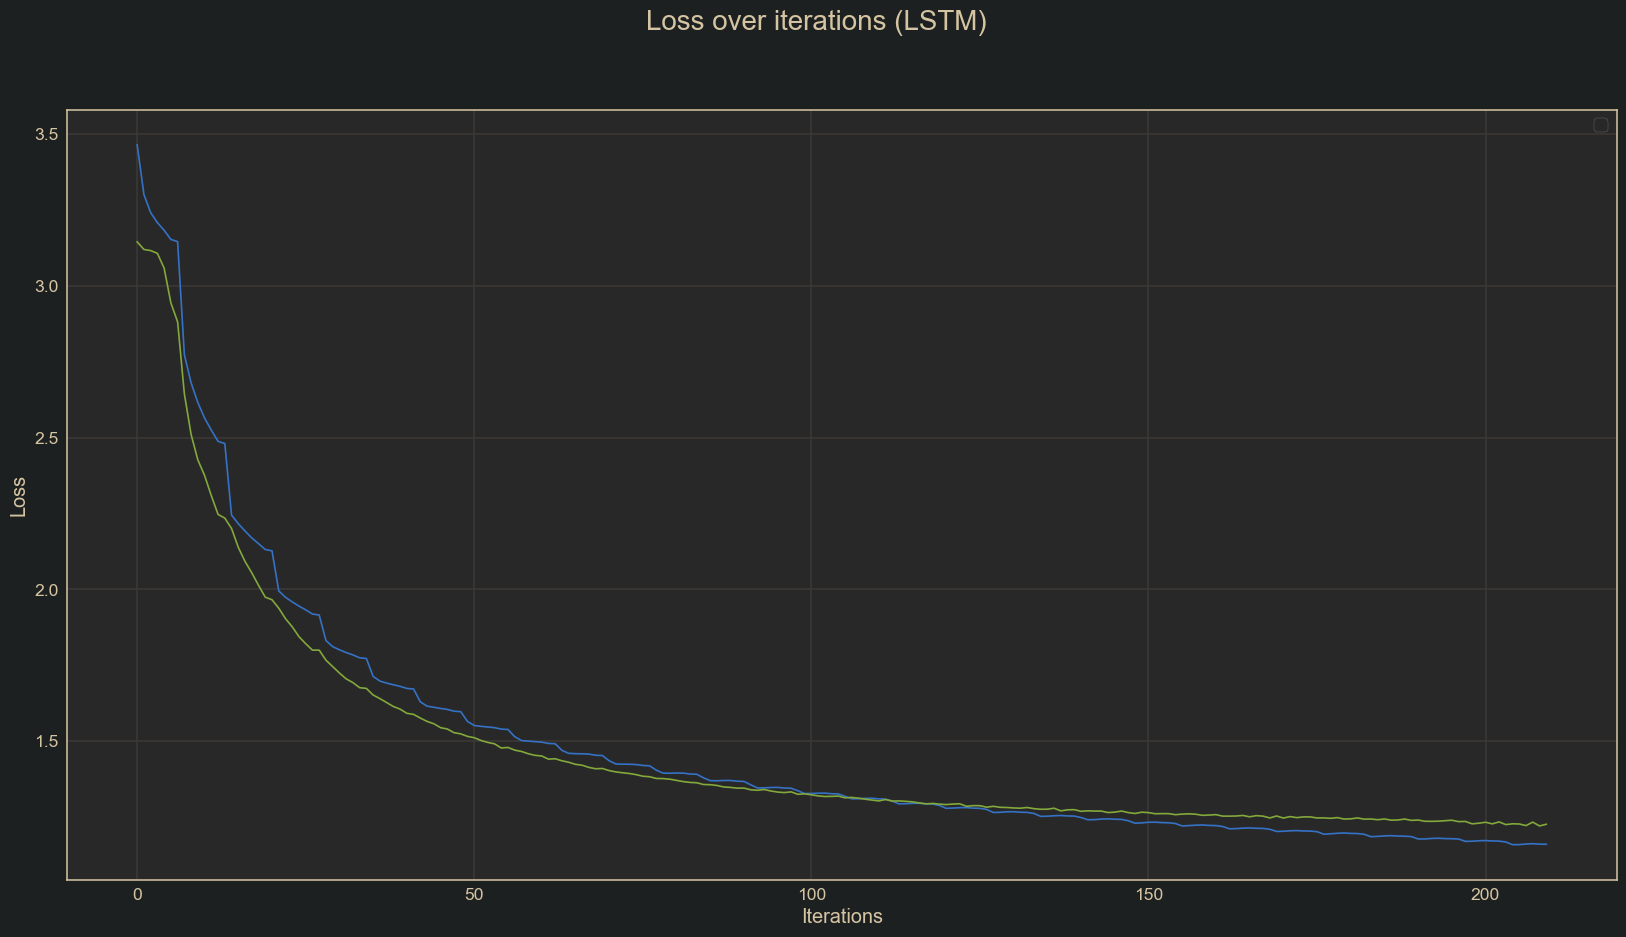

In [49]:
plt.figure(figsize = (20, 10))
plt.plot(range(len(running_train_loss)), running_train_loss, range(len(running_val_loss)), running_val_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.suptitle("Loss over iterations (LSTM)", fontsize = 20)
plt.legend()
plt.show(); plt.close("all")

In [50]:
### Freeze model weights
model.requires_grad_ = False

In [51]:
int2char = encoding_results.int2char
char2int = encoding_results.char2int

In [52]:
seed = "Lan al'Mandragoran went up the mountain"
k = 5

In [53]:
def predict(x, h, net, k = 5):
    x = np.array([[char2int[x]]])
    x = one_hot_encode(x, len(unique_chars))
    x = torch.from_numpy(x).to(device).contiguous()
    
    out, h = net(x, h)
    p = F.softmax(out, dim = -1).data
    p, chars = p.topk(k, dim = -1)
    
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    
    return np.random.choice(chars, p = p/p.sum()), h

In [54]:
a = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_()
b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size)).zero_()
h = (a.to(device), b.to(device))

predict("D", h, model, 5)

(20,
 (tensor([[[ 0.0968, -0.2374,  0.1266,  ..., -0.0860,  0.0987, -0.0934]],
  
          [[ 0.2269, -0.2540,  0.1349,  ..., -0.1243, -0.0698,  0.0599]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward0>),
  tensor([[[ 0.2047, -0.3630,  0.1963,  ..., -0.1409,  0.1715, -0.1539]],
  
          [[ 0.4648, -0.6441,  0.3031,  ..., -0.1590, -0.1269,  0.1992]]],
         device='cuda:0', grad_fn=<CudnnRnnBackward0>)))

In [55]:
def prime_model(model, seed, k):
    seed_list = list(seed)

    h = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
    if model.base_rnn == nn.LSTM:
        b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
        h = (h.to(device), b.to(device))

    for char in seed_list:
        h = tuple([each.data for each in h]) if type(h) == tuple else h.data
        next_char, h = predict(char, h, model, k)

    seed_list.append(int2char[next_char])

    return seed_list, h

seed_list = list(seed)

a = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
b = torch.distributions.Normal(scale = 0.5, loc = 0.).sample((num_layers, 1, hidden_size))
h = (a.to(device), b.to(device))

for char in seed_list:
    h = tuple([each.data for each in h])
    next_char, h = predict(char, h, model, k)

seed_list.append(int2char[next_char])
seed_list_1 = seed_list.copy()
seed_list_2 = seed_list.copy()

In [56]:
first_seed_list, h = prime_model(model, seed, k)

In [57]:
print(''.join(first_seed_list))

Lan al'Mandragoran went up the mountain



In [58]:
## Method 1
for ii in range(1000):
    h = tuple([each.data for each in h])
    next_char, h = predict(first_seed_list[-1], h, model, k)
    first_seed_list.append(int2char[next_char])

In [59]:
seed = "Why would you imagine that"

second_seed_list, h = prime_model(model, seed, k)

In [60]:
## Method 2
for ix in range(1000):
    h = tuple([each.data.to(device) for each in h])
    x = np.array(char2int[second_seed_list[-1]]).reshape(1, -1)
    x = one_hot_encode(x, len(unique_char))
    x = torch.tensor(x).to(device)
    out, h = model(x, h)
    
    p = F.softmax(out, dim=-1)
    p, chars = p.topk(k = k, dim=-1)
    chars = chars.detach().cpu().numpy().squeeze()
    p = p.detach().cpu().numpy().squeeze()
    second_seed_list.append(int2char[np.random.choice(chars, p = p/p.sum())])
    #next_char = chars[torch.distributions.Uniform(low = 0, high = k).sample().to(torch.int32).item()].item()
    #seed_list.append(int2char[next_char])
    

In [61]:
### First generated text sample
first_pred_text = ''.join(first_seed_list)

In [62]:
print(first_pred_text)

Lan al'Mandragoran went up the mountain
of the point of the poirts, but the more the position of her happy. The conversation was not
a single day at their personal. Anna's bitteres, bushing
him. His brother in her face had not she heard him and having,
as at once, who had already forgetting to be still more than as how she
saw his show and all, serious his mane high brows, and the
carping of the window with her set of the corridor and shook his eyes.

Sergey Ivanovitch stood staying at him.

"Ah! the son, and stay, and I will cannot take to my prayers, I say that I suspose the
same side.... They wants to me so some tone of thoughts."

"Well, are you going to start things without my, but you know, and we could
say. But is that his hands,
which
you're all abroad, while I can't get off. There's no terror of them
into the mirthfulne, though I should
not go or and should she have been as in the
party there has a spreng on the sick of the three-grass and a peace, whatever it were
anything
al

In [63]:
### Second generated text sample
second_pred_text = ''.join(second_seed_list)

In [64]:
print(second_pred_text)

Why would you imagine that it
supportured it all such a minute, that through her shore transler in a
profosmic and sense of things, and a standing minute, the
children, it's not a confust of it. But has it saying that the sound of
her legs as they can talk to her. Have you see that."

"What would you go on. To be done!" she whispered.

"Ah! you're not to see him thinking of at that side," she added, and he was
carried theres in the conversation with the most counting second
state of a gloomy winkow, and his stall she did not know his strange the
surprise.

"I don't like it," said Levin, would be all of his sister-in-law,
and the moment's half and heary, all of them service, and to speak of
the party of the morning on the side of all her face. The marshal of the
privan true of the words was something so as the only one was that he
was a chance of social son. He felt, he went out of the
cheeks of this carriage had
been been work and considerations of her husband and
anyone he had saw tha